# Geographic Correlation and Oceanic Tools

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import pymc3 as pm

//anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


##### Data: data/Kline2.csv, data/distmatrix.csv

## Reading in our data

We read back the Oceanic tools data

In [2]:
df = pd.read_csv("data/Kline2.csv", sep=';')
df.head()

,culture,population,contact,total_tools,mean_TU,lat,lon,lon2,logpop
0,Malekula,1100,low,13,3.2,-16.3,167.5,-12.5,7.003065
1,Tikopia,1500,low,22,4.7,-12.3,168.8,-11.2,7.313220
2,Santa Cruz,3600,low,24,4.0,-10.7,166.0,-14.0,8.188689
3,Yap,4791,high,43,5.0,9.5,138.1,-41.9,8.474494
4,Lau Fiji,7400,high,33,5.0,-17.7,178.1,-1.9,8.909235


And center it

In [3]:
df.logpop_c = df.logpop - df.logpop.mean()

In [4]:
df.head()

,culture,population,contact,total_tools,mean_TU,lat,lon,lon2,logpop
0,Malekula,1100,low,13,3.2,-16.3,167.5,-12.5,7.003065
1,Tikopia,1500,low,22,4.7,-12.3,168.8,-11.2,7.313220
2,Santa Cruz,3600,low,24,4.0,-10.7,166.0,-14.0,8.188689
3,Yap,4791,high,43,5.0,9.5,138.1,-41.9,8.474494
4,Lau Fiji,7400,high,33,5.0,-17.7,178.1,-1.9,8.909235


And read in the distance matrix

In [35]:
dfd = pd.read_csv("data/distmatrix.csv", header=None)
dij=dfd.values
dij

array([[ 0.   ,  0.475,  0.631,  4.363,  1.234,  2.036,  3.178,  2.794,
         1.86 ,  5.678],
       [ 0.475,  0.   ,  0.315,  4.173,  1.236,  2.007,  2.877,  2.67 ,
         1.965,  5.283],
       [ 0.631,  0.315,  0.   ,  3.859,  1.55 ,  1.708,  2.588,  2.356,
         2.279,  5.401],
       [ 4.363,  4.173,  3.859,  0.   ,  5.391,  2.462,  1.555,  1.616,
         6.136,  7.178],
       [ 1.234,  1.236,  1.55 ,  5.391,  0.   ,  3.219,  4.027,  3.906,
         0.763,  4.884],
       [ 2.036,  2.007,  1.708,  2.462,  3.219,  0.   ,  1.801,  0.85 ,
         3.893,  6.653],
       [ 3.178,  2.877,  2.588,  1.555,  4.027,  1.801,  0.   ,  1.213,
         4.789,  5.787],
       [ 2.794,  2.67 ,  2.356,  1.616,  3.906,  0.85 ,  1.213,  0.   ,
         4.622,  6.722],
       [ 1.86 ,  1.965,  2.279,  6.136,  0.763,  3.893,  4.789,  4.622,
         0.   ,  5.037],
       [ 5.678,  5.283,  5.401,  7.178,  4.884,  6.653,  5.787,  6.722,
         5.037,  0.   ]])

## Implementing the simple tools:logpop model and varying intercepts models

In [37]:
import theano.tensor as tt

In [6]:
import theano.tensor as t
with pm.Model() as m2c_onlyp:
    betap = pm.Normal("betap", 0, 1)
    alpha = pm.Normal("alpha", 0, 100)
    loglam = alpha + betap*df.logpop_c
    y = pm.Poisson("ntools", mu=t.exp(loglam), observed=df.total_tools)
    trace2c_onlyp = pm.sample(5000, njobs=2)

100%|██████████| 5000/5000 [00:33<00:00, 147.16it/s]


In [60]:
pm.summary(trace2c_onlyp)


betap:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.240            0.031            0.000            [0.181, 0.303]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.178          0.219          0.240          0.260          0.301


alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  3.478            0.058            0.001            [3.364, 3.594]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  3.360          3.441          3.478          3.517          3.591



Notice that $\beta_P$ has a value around 0.24

We also implement the varying intercepts per society model from before

In [58]:
with pm.Model() as m3c:
    betap = pm.Normal("betap", 0, 1)
    alpha = pm.Normal("alpha", 0, 100)
    sigmasoc = pm.HalfCauchy("sigmasoc", 1)
    alphasoc = pm.Normal("alphasoc", 0, sigmasoc, shape=df.shape[0])
    loglam = alpha + alphasoc + betap*df.logpop_c 
    y = pm.Poisson("ntools", mu=t.exp(loglam), observed=df.total_tools)
with m3c:
    trace3 = pm.sample(5000, njobs=2)

100%|██████████| 5000/5000 [00:23<00:00, 212.89it/s]


In [59]:
pm.summary(trace3)


betap:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.260            0.083            0.002            [0.097, 0.432]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.095          0.210          0.258          0.308          0.431


alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  3.447            0.124            0.002            [3.188, 3.680]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  3.195          3.374          3.450          3.523          3.688


alphasoc:

  Mean             SD               MC Error         95% HPD interval
  ----------------------

## A model with a custom covariance matrix

We use a custom covariance matrix which inverse-square weights distance

![](images/covgp.png)

This is an example of a Gaussian Process Covariance Matrix. We'll learn more about this in lecture.

Here is the complete model:

![](images/modelgp.png)

In [65]:
with pm.Model() as mgc:
    betap = pm.Normal("betap", 0, 1)
    alpha = pm.Normal("alpha", 0, 10)
    etasq = pm.HalfCauchy("etasq", 1)
    rhosq = pm.HalfCauchy("rhosq", 1)
    means=tt.stack([0.0]*10)
    sigma_matrix = tt.nlinalg.diag([0.01]*10)
    cov=tt.exp(-rhosq*dij*dij)*etasq + sigma_matrix
    gammasoc = pm.MvNormal("gammasoc", means, cov=cov, shape=df.shape[0])
    loglam = alpha + gammasoc + betap*df.logpop_c 
    y = pm.Poisson("ntools", mu=t.exp(loglam), observed=df.total_tools)

In [66]:
with mgc:
    mgctrace = pm.sample(30000)

100%|██████████| 30000/30000 [04:22<00:00, 114.20it/s]


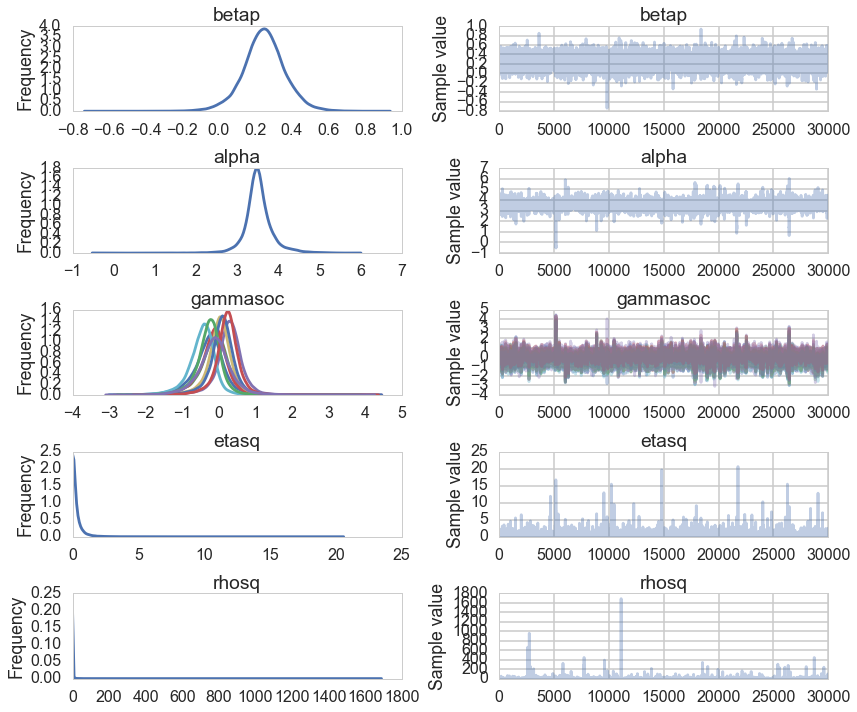

In [67]:
pm.traceplot(mgctrace);

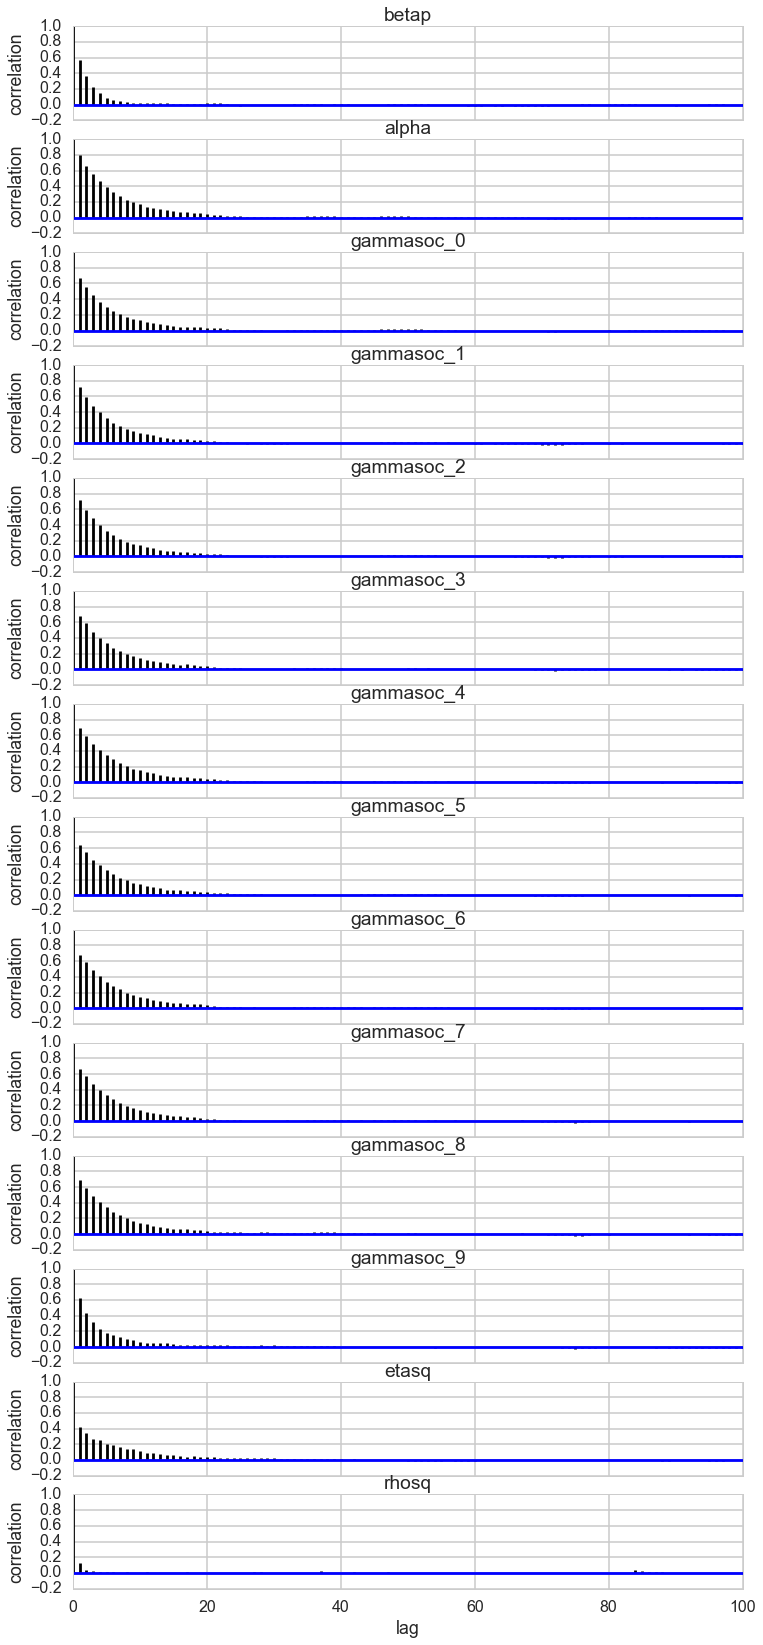

In [68]:
pm.autocorrplot(mgctrace);

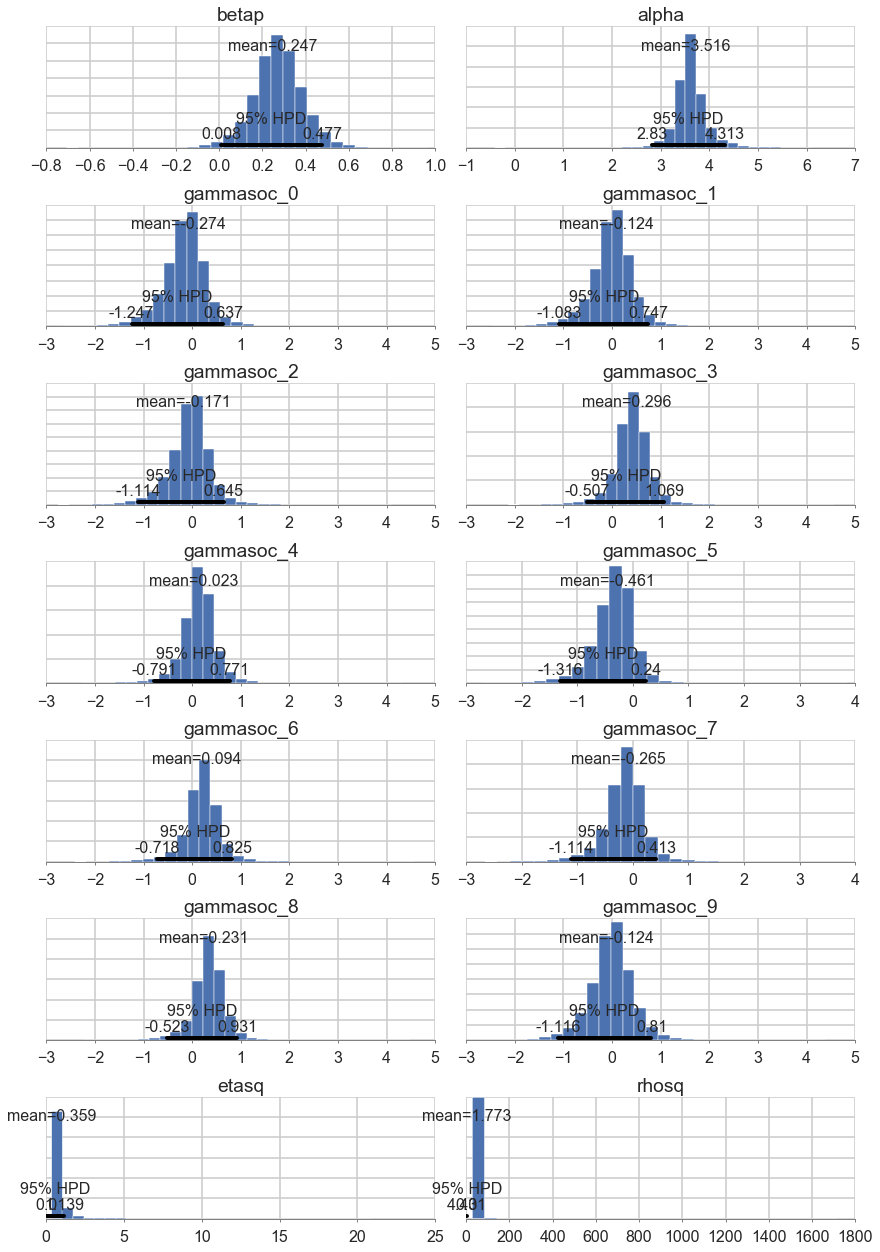

In [69]:
pm.plot_posterior(mgctrace);

In [70]:
d={}
for i, v in enumerate(df.culture.values):
    d[v] = mgctrace['gammasoc'][:,i]
dfsamps=pd.DataFrame.from_dict(d)
dfsamps.head()

,Chuuk,Hawaii,Lau Fiji,Malekula,Manus,Santa Cruz,Tikopia,Tonga,Trobriand,Yap
0,0.836138,0.304428,0.820912,0.816184,0.536671,0.590162,0.559185,0.893075,0.024161,1.243371
1,0.836138,0.304428,0.820912,0.816184,0.536671,0.590162,0.559185,0.893075,0.024161,1.243371
2,0.703682,0.504951,0.730426,0.540004,0.519810,0.663994,0.681683,0.971137,-0.008614,1.205802
3,0.567167,0.534332,0.916450,0.164368,0.444714,0.804241,0.773782,0.883073,0.289772,1.032754
4,-0.683220,-0.089243,-0.643991,-1.336777,-0.979924,-0.969825,-1.143890,-0.470816,-1.322837,-0.346867


In [71]:
dfsamps.describe()

,Chuuk,Hawaii,Lau Fiji,Malekula,Manus,Santa Cruz,Tikopia,Tonga,Trobriand,Yap
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,0.094261,-0.124028,0.023465,-0.273515,-0.265189,-0.170598,-0.124225,0.231100,-0.460621,0.295641
std,0.385037,0.480892,0.388604,0.462563,0.387340,0.436725,0.450476,0.369004,0.397420,0.393198
min,-2.529666,-3.093213,-2.614361,-2.995777,-2.774822,-2.871235,-2.798763,-2.348071,-3.021011,-2.247205
25%,-0.083272,-0.379004,-0.158029,-0.503521,-0.444747,-0.376714,-0.343255,0.065343,-0.651914,0.110146
50%,0.104171,-0.119327,0.035521,-0.242750,-0.243438,-0.139088,-0.100060,0.240586,-0.426263,0.302898
75%,0.285664,0.128399,0.215014,-0.017278,-0.063474,0.067777,0.121864,0.408959,-0.237074,0.495714
max,4.446998,4.257859,4.204263,3.921945,3.886337,3.996297,3.905850,4.363513,3.742380,4.457200


In [72]:
pm.summary(mgctrace)


betap:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.247            0.117            0.001            [0.008, 0.477]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.009          0.178          0.247          0.317          0.478


alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  3.516            0.365            0.006            [2.830, 4.313]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  2.859          3.350          3.494          3.661          4.348


gammasoc:

  Mean             SD               MC Error         95% HPD interval
  ----------------------

## Plotting posteriors and predictives

Lets plot the covariance posteriors.

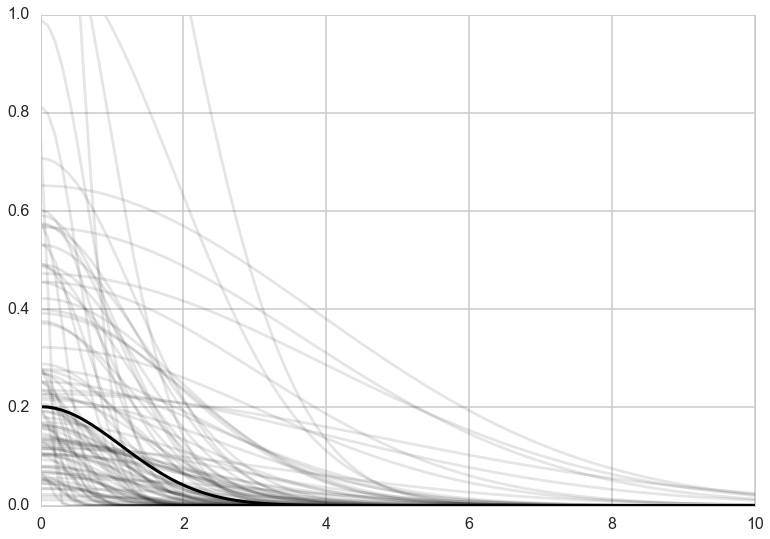

In [77]:
smalleta=np.random.choice(mgctrace['etasq'], replace=False, size=100)
smallrho=np.random.choice(mgctrace['rhosq'], replace=False, size=100)
d=np.linspace(0,10,100)
for i in range(100):
    covarod = lambda d: smalleta[i]*np.exp(-smallrho[i]*d*d)
    plt.plot(d, covarod(d),alpha=0.1, color='k')
medetasq=np.median(mgctrace['etasq'])
medrhosq=np.median(mgctrace['rhosq'])
covarodmed = lambda d: medetasq*np.exp(-medrhosq*d*d)
plt.plot(d, covarodmed(d),alpha=1.0, color='k', lw=3)
plt.ylim([0,1]); 

The x-axis is thousands of kilometers. Notice how almost everything damps out by 4000 kms. Lets calculate the median correlation matrix:

In [78]:
medkij = np.diag([0.01]*10)+medetasq*(np.exp(-medrhosq*dij*dij))

In [81]:
#from statsmodels
def cov2corr(cov, return_std=False):
    '''convert covariance matrix to correlation matrix

    Parameters
    ----------
    cov : array_like, 2d
        covariance matrix, see Notes

    Returns
    -------
    corr : ndarray (subclass)
        correlation matrix
    return_std : bool
        If this is true then the standard deviation is also returned.
        By default only the correlation matrix is returned.

    Notes
    -----
    This function does not convert subclasses of ndarrays. This requires
    that division is defined elementwise. np.ma.array and np.matrix are allowed.

    '''
    cov = np.asanyarray(cov)
    std_ = np.sqrt(np.diag(cov))
    corr = cov / np.outer(std_, std_)
    if return_std:
        return corr, std_
    else:
        return corr

In [83]:
medcorrij=cov2corr(medkij)
medcorrij

array([[  1.00000000e+00,   8.71753319e-01,   8.14523188e-01,
          5.31288769e-04,   5.23221633e-01,   1.86395976e-01,
          1.78937777e-02,   4.41233043e-02,   2.44138854e-01,
          2.94099446e-06],
       [  8.71753319e-01,   1.00000000e+00,   9.16216525e-01,
          1.00586197e-03,   5.22205376e-01,   1.95198554e-01,
          3.66620167e-02,   5.76067901e-02,   2.08444504e-01,
          1.61627858e-05],
       [  8.14523188e-01,   9.16216525e-01,   1.00000000e+00,
          2.71400897e-03,   3.70099328e-01,   3.02227464e-01,
          6.82602100e-02,   1.07205298e-01,   1.23372218e-01,
          9.84086103e-06],
       [  5.31288769e-04,   1.00586197e-03,   2.71400897e-03,
          1.00000000e+00,   1.02678372e-05,   8.76849660e-02,
          3.67844898e-01,   3.40881293e-01,   3.49678298e-07,
          1.48743820e-09],
       [  5.23221633e-01,   5.22205376e-01,   3.70099328e-01,
          1.02678372e-05,   1.00000000e+00,   1.61388725e-02,
          1.61126110e-03

We'll data frame it to see clearly

In [87]:
dfcorr = pd.DataFrame(medcorrij*100).set_index(df.culture.values)
dfcorr.columns = df.culture.values
dfcorr

,Malekula,Tikopia,Santa Cruz,Yap,Lau Fiji,Trobriand,Chuuk,Manus,Tonga,Hawaii
Malekula,100.000000,87.175332,81.452319,5.312888e-02,52.322163,18.639598,1.789378,4.412330,24.413885,2.940994e-04
Tikopia,87.175332,100.000000,91.621652,1.005862e-01,52.220538,19.519855,3.666202,5.760679,20.844450,1.616279e-03
Santa Cruz,81.452319,91.621652,100.000000,2.714009e-01,37.009933,30.222746,6.826021,10.720530,12.337222,9.840861e-04
Yap,0.053129,0.100586,0.271401,1.000000e+02,0.001027,8.768497,36.784490,34.088129,0.000035,1.487438e-07
Lau Fiji,52.322163,52.220538,37.009933,1.026784e-03,100.000000,1.613887,0.161126,0.235089,75.762183,7.977799e-03
Trobriand,18.639598,19.519855,30.222746,8.768497e+00,1.613887,100.000000,26.580052,71.691367,0.244659,2.591486e-06
Chuuk,1.789378,3.666202,6.826021,3.678449e+01,0.161126,26.580052,100.000000,53.391098,0.011454,1.798440e-04
Manus,4.412330,5.760679,10.720530,3.408813e+01,0.235089,71.691367,53.391098,100.000000,0.021261,1.802227e-06
Tonga,24.413885,20.844450,12.337222,3.496783e-05,75.762183,0.244659,0.011454,0.021261,100.000000,4.389739e-03
Hawaii,0.000294,0.001616,0.000984,1.487438e-07,0.007978,0.000003,0.000180,0.000002,0.004390,1.000000e+02


Notice how there is correlation in the upper left and with Manus and Trobriand. Mcelreath has a distance plot i reproduce below:

![](images/pacisl.png)

To produce a plot like the one on the right, we calculate the posterior predictives with the correlation free part of the model and then overlay the correlations

In [96]:
from scipy.stats import poisson
def compute_pp_no_corr(lpgrid, trace, contact=0):
    alphatrace = trace['alpha']
    betaptrace = trace['betap']
    tl=len(trace)
    gl=lpgrid.shape[0]
    lam = np.empty((gl, tl))
    lpgrid = lpgrid - lpgrid.mean()
    for i, v in enumerate(lpgrid):
        temp = alphatrace + betaptrace*lpgrid[i]
        lam[i,:] = poisson.rvs(np.exp(temp))
    return lam

In [97]:
lpgrid = np.linspace(6,13,30)
pp = compute_pp_no_corr(lpgrid, mgctrace)
ppmed = np.median(pp, axis=1)
pphpd = pm.stats.hpd(pp.T)

In [105]:
import itertools
corrs={}
for i, j in itertools.product(range(10), range(10)):
    if i <j:
        corrs[(i,j)]=medcorrij[i,j]
corrs

{(0, 1): 0.87175331894679542,
 (0, 2): 0.81452318764516185,
 (0, 3): 0.0005312887693770125,
 (0, 4): 0.52322163333581462,
 (0, 5): 0.18639597583912959,
 (0, 6): 0.017893777703797374,
 (0, 7): 0.044123304343115725,
 (0, 8): 0.2441388537333383,
 (0, 9): 2.9409944575745014e-06,
 (1, 2): 0.91621652465271597,
 (1, 3): 0.0010058619681967689,
 (1, 4): 0.52220537625374963,
 (1, 5): 0.19519855390239216,
 (1, 6): 0.036662016744262151,
 (1, 7): 0.05760679006552407,
 (1, 8): 0.20844450372882933,
 (1, 9): 1.6162785759359423e-05,
 (2, 3): 0.0027140089663475748,
 (2, 4): 0.37009932820968272,
 (2, 5): 0.30222746359218788,
 (2, 6): 0.068260209995050544,
 (2, 7): 0.10720529827354075,
 (2, 8): 0.12337221784883008,
 (2, 9): 9.8408610265260269e-06,
 (3, 4): 1.0267837228247049e-05,
 (3, 5): 0.087684965970167339,
 (3, 6): 0.36784489769928813,
 (3, 7): 0.34088129328266803,
 (3, 8): 3.4967829832498871e-07,
 (3, 9): 1.4874381952657726e-09,
 (4, 5): 0.016138872497577089,
 (4, 6): 0.0016112611003146423,
 (4, 7): 

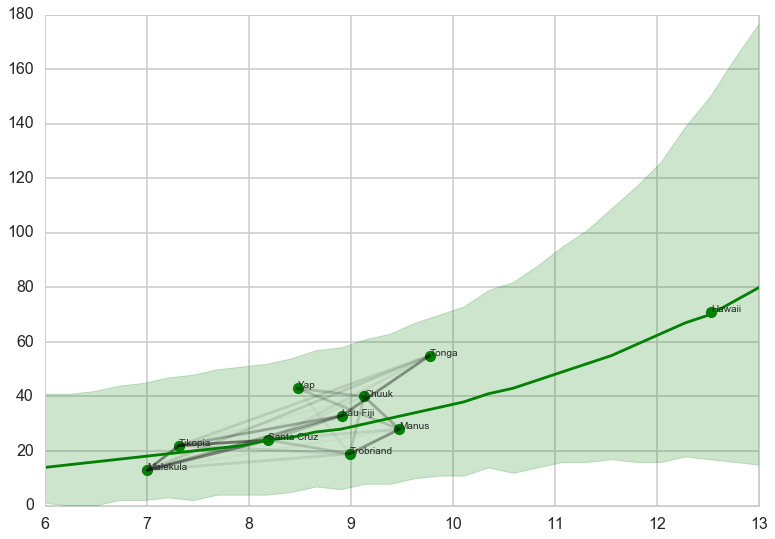

In [109]:
plt.plot(df.logpop, df.total_tools,'o', color="g")
lpv = df.logpop.values
ttv = df.total_tools.values
for a,x,y in zip(df.culture.values, lpv, ttv):
    plt.annotate(a, xy=(x,y))
for i in range(10):
    for j in range(10):
        if i < j:
            plt.plot([lpv[i],lpv[j]],[ttv[i], ttv[j]],'k', alpha=corrs[(i,j)]/2.)
plt.plot(lpgrid, ppmed, color="g")
plt.fill_between(lpgrid, pphpd[:,0], pphpd[:,1], color="g", alpha=0.2, lw=1)

Notice how distance probably pulls Fiji up from the median, and how Manus and Trobriand are below the median but highly correlated. A smaller effect can be seen with the triangle on the left. Of-course, causality is uncertain